# Parte 1

A primeira parte do trabalho prático tem dois objectivos:

* introduzir de uma forma mais prática os conceitos de python e pandas;
* ter contacto com os dados através de uma exploração dos mesmos para melhor se perceber o domínio.

Irei usar o desafio [2015 Flight Delays and Cancellations](https://www.kaggle.com/usdot/flight-delays) do Kaggle como base para todo o trabalho. 

Os dados já se encontram no ambiente disponibilizado no diretório `/home/vagrant/course/python/flight_delays/data/`. Notem que o ficheiro foi alterado para ter dados até Junho (inc). A estrutura dos ficheiros foi mantida, por isso podem considerar estas [definições](https://www.kaggle.com/usdot/flight-delays/data).


O índice da primeira parte é o seguinte:

**1. Ler datasets** <br>
**2. Obter estatísticas dos dados** <br>
- 2.1 Tipo dos dados
- 2.2 Valores nulos
- 2.3 Estatísticas para cada coluna

**3. Pré-processar os dados** <br>
- 3.1 Trabalhar os campos de datas
- 3.2 Remover campos desnecessarios

**4. Começar data understanding** <br>
**5. Desafios** <br>

___

Vamos começar por carregar todas as dependências que podemos vir a usar. 

In [1]:
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
# https://plot.ly/python/offline/
import plotly.offline as py

from os import listdir
from os.path import isfile, join
from sklearn import linear_model
from pandas import Series
from utilities import *

# inline matplotlib plots
%matplotlib inline
# inline plotly plots
py.init_notebook_mode(connected=True)

# all pandas prints will have this format
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option("display.max_columns", 100)
pd.set_option('display.max_rows', 200)

# Reload all modules (except those excluded by %aimport) before executing the Python code typed.
# http://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['figure.figsize'] = 12, 8  # default image size

___
### 1. Ler datasets
___

Antes de carregar os dados em memória vamos confirmar que ficheiros existem:

In [3]:
import os
path = join(os.getcwd(), 'data')

# further reading regarding join function
# https://docs.python.org/3.6/library/os.path.html#os.path.join
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
assert sorted(onlyfiles) == ['airlines.csv', 'airports.csv', 'flights_until_june.csv']
print(onlyfiles)

['airlines.csv', 'airports.csv', 'flights_until_june.csv']


Sendo que os ficheiros são os esperados, podemos proceder com a leitura dos mesmos. 

In [4]:
airlines = pd.read_csv(join(path, 'airlines.csv'))
airports = pd.read_csv(join(path, 'airports.csv'))
flights = read_flights_data(join(path, 'flights_until_june.csv'))

# confirm number of rows and columns per dataset
assert airlines.shape == (14, 2)
assert airports.shape == (322, 7)
assert flights.shape == (2889512, 31)
print('Airlines:', airlines.shape)
print('Airports:', airports.shape)
print(' Flights:', flights.shape)

Airlines: (14, 2)
Airports: (322, 7)
 Flights: (2889512, 31)


<div class="alert alert-success">
Q.1<br>
  Nas próximas 3 células mostre as primeiras linhas de cada dataset. Sendo que apenas existem 14 companhias aéreas (dataframe <code>airlines</code>), para este mostre todo o dataset, para os restantes mostre as primeiras 10 linhas de cada dataset.
  <br><br>
  Tire algum tempo para analisar os dados que vê, comparar com o que esperava e com a definição dos campos presente no site do Kaggle.
</div>

In [5]:
# Airlines
assert len(airlines) == len(airlines.head(14))
airlines

,iata_code,airline
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [6]:
# Airports
airports.head(10)

,iata_code,airport,city,state,country,latitude,longitude
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.652,-75.440
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.411,-99.682
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.040,-106.609
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.449,-98.422
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.536,-84.194
5,ACK,Nantucket Memorial Airport,Nantucket,MA,USA,41.253,-70.060
6,ACT,Waco Regional Airport,Waco,TX,USA,31.611,-97.231
7,ACV,Arcata Airport,Arcata/Eureka,CA,USA,40.978,-124.109
8,ACY,Atlantic City International Airport,Atlantic City,NJ,USA,39.458,-74.577
9,ADK,Adak Airport,Adak,AK,USA,51.878,-176.646


In [7]:
# Flights
flights.head(10)

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5.000,"2,354.000",-11.000,21.000,15.000,205.000,194.000,169.000,1448,404.000,4.000,430.000,408.000,-22.000,False,False,NaN,nan,nan,nan,nan,nan
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10.000,2.000,-8.000,12.000,14.000,280.000,279.000,263.000,2330,737.000,4.000,750.000,741.000,-9.000,False,False,NaN,nan,nan,nan,nan,nan
2,2015,1,1,4,US,840,N171US,SFO,CLT,20.000,18.000,-2.000,16.000,34.000,286.000,293.000,266.000,2296,800.000,11.000,806.000,811.000,5.000,False,False,NaN,nan,nan,nan,nan,nan
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20.000,15.000,-5.000,15.000,30.000,285.000,281.000,258.000,2342,748.000,8.000,805.000,756.000,-9.000,False,False,NaN,nan,nan,nan,nan,nan
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25.000,24.000,-1.000,11.000,35.000,235.000,215.000,199.000,1448,254.000,5.000,320.000,259.000,-21.000,False,False,NaN,nan,nan,nan,nan,nan
5,2015,1,1,4,DL,806,N3730B,SFO,MSP,25.000,20.000,-5.000,18.000,38.000,217.000,230.000,206.000,1589,604.000,6.000,602.000,610.000,8.000,False,False,NaN,nan,nan,nan,nan,nan
6,2015,1,1,4,NK,612,N635NK,LAS,MSP,25.000,19.000,-6.000,11.000,30.000,181.000,170.000,154.000,1299,504.000,5.000,526.000,509.000,-17.000,False,False,NaN,nan,nan,nan,nan,nan
7,2015,1,1,4,US,2013,N584UW,LAX,CLT,30.000,44.000,14.000,13.000,57.000,273.000,249.000,228.000,2125,745.000,8.000,803.000,753.000,-10.000,False,False,NaN,nan,nan,nan,nan,nan
8,2015,1,1,4,AA,1112,N3LAAA,SFO,DFW,30.000,19.000,-11.000,17.000,36.000,195.000,193.000,173.000,1464,529.000,3.000,545.000,532.000,-13.000,False,False,NaN,nan,nan,nan,nan,nan
9,2015,1,1,4,DL,1173,N826DN,LAS,ATL,30.000,33.000,3.000,12.000,45.000,221.000,203.000,186.000,1747,651.000,5.000,711.000,656.000,-15.000,False,False,NaN,nan,nan,nan,nan,nan


Na 1ª parte do trabalho prático iremo-nos concentrar apenas no dataset de voos, dataframe `flights`.

___
### 2. Obter estatísticas dos dados 
___

#### 2.1 Tipo dos dados

In [8]:
flights.dtypes

year                      int32
month                     int32
day                       int32
day_of_week               int32
airline                category
flight_number             int32
tail_number              object
origin_airport           object
destination_airport      object
scheduled_departure     float32
departure_time          float32
departure_delay         float32
taxi_out                float32
wheels_off              float32
scheduled_time          float32
elapsed_time            float32
air_time                float32
distance                  int32
wheels_on               float32
taxi_in                 float32
scheduled_arrival       float32
arrival_time            float32
arrival_delay           float32
diverted                   bool
cancelled                  bool
cancellation_reason    category
air_system_delay        float32
security_delay          float32
airline_delay           float32
late_aircraft_delay     float32
weather_delay           float32
dtype: o

Notem que eu defino os tipos de dados deste dataset no momento da leitura (no módulo `utilities`).

#### 2.2 Valores nulos

In [9]:
flights.isnull().sum()

year                         0
month                        0
day                          0
day_of_week                  0
airline                      0
flight_number                0
tail_number              10824
origin_airport               0
destination_airport          0
scheduled_departure          0
departure_time           60642
departure_delay          60642
taxi_out                 62317
wheels_off               62317
scheduled_time               6
elapsed_time             70959
air_time                 70959
distance                     0
wheels_on                64385
taxi_in                  64385
scheduled_arrival            0
arrival_time             64385
arrival_delay            70959
diverted                     0
cancelled                    0
cancellation_reason    2826677
air_system_delay       2315296
security_delay         2315296
airline_delay          2315296
late_aircraft_delay    2315296
weather_delay          2315296
dtype: int64

<div class="alert alert-success">
Q.2<br>
Aproveite o código da célula anterior e altere-o de forma a obter a percentagem de nulos por coluna. Apresente por ordem descendente.
<br><br>
O top-7 deverá ser:<br>
    
```
cancellation_reason    97.83%
weather_delay          80.13%
airline_delay          80.13%
security_delay         80.13%
air_system_delay       80.13%
late_aircraft_delay    80.13%
arrival_delay           2.46%
```

</div>

In [10]:
# percentage of nulls per column

null_sum = flights.isnull().sum()
total_flights = len(flights)
null_percent = (null_sum * 100) / total_flights

null_percent_form = null_percent.sort_values(ascending=False).map(lambda x: "{:02.02f}%".format(x))
print(null_percent_form)

cancellation_reason    97.83%
weather_delay          80.13%
airline_delay          80.13%
security_delay         80.13%
air_system_delay       80.13%
late_aircraft_delay    80.13%
arrival_delay           2.46%
air_time                2.46%
elapsed_time            2.46%
arrival_time            2.23%
taxi_in                 2.23%
wheels_on               2.23%
wheels_off              2.16%
taxi_out                2.16%
departure_delay         2.10%
departure_time          2.10%
tail_number             0.37%
scheduled_time          0.00%
cancelled               0.00%
diverted                0.00%
distance                0.00%
scheduled_arrival       0.00%
scheduled_departure     0.00%
destination_airport     0.00%
origin_airport          0.00%
flight_number           0.00%
airline                 0.00%
day_of_week             0.00%
day                     0.00%
month                   0.00%
year                    0.00%
dtype: object


#### 2.3 Estatísticas para cada coluna

In [11]:
# columns type distribution
flights.dtypes.value_counts()

float32     18
int32        6
object       3
bool         2
category     1
category     1
dtype: int64

De seguida iremos analisar cada coluna individualmente. Para colunas numéricas normalmente verificam-se indicadores como a média, valor mínimo, valor máximo e alguns percentis. Para os restantes tipos (`string`, `boolean` e `category`) pode-se analisar o top-10 valores mais frequentes.
<br><br>
<div class="alert alert-success">
Q.3<br>
Nas próximas células implemente o código necessário para efetuar esta análise.
<br><br>
    Relativamente às variáveis não numéricas implemente a função <code>most_frequent_values</code>.
</div>

In [12]:
# numerical columns  
flights.describe()

,year,month,day,day_of_week,flight_number,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay
count,"2,889,512.000","2,889,512.000","2,889,512.000","2,889,512.000","2,889,512.000","2,889,512.000","2,828,870.000","2,828,870.000","2,827,195.000","2,827,195.000","2,889,506.000","2,818,553.000","2,818,553.000","2,889,512.000","2,825,127.000","2,825,127.000","2,889,512.000","2,825,127.000","2,818,553.000","574,216.000","574,216.000","574,216.000","574,216.000","574,216.000"
mean,"2,015.000",3.561,15.602,3.930,"2,203.224","1,329.343","1,337.278",10.394,16.136,"1,359.579",141.163,137.071,113.563,816.530,"1,474.054",7.409,"1,496.806","1,478.867",6.001,13.688,0.060,18.624,23.531,3.208
std,0.000,1.706,8.722,1.991,"1,776.103",480.907,494.358,38.388,9.220,496.213,74.846,74.044,71.938,602.269,521.021,5.709,503.725,525.104,40.614,28.005,1.815,47.203,43.034,21.618
min,"2,015.000",1.000,1.000,1.000,1.000,1.000,1.000,-68.000,1.000,1.000,18.000,15.000,7.000,21.000,1.000,1.000,1.000,1.000,-87.000,0.000,0.000,0.000,0.000,0.000
25%,"2,015.000",2.000,8.000,2.000,738.000,920.000,923.000,-5.000,11.000,938.000,85.000,82.000,60.000,372.000,"1,057.000",4.000,"1,112.000","1,102.000",-13.000,0.000,0.000,0.000,0.000,0.000
50%,"2,015.000",4.000,16.000,4.000,"1,684.000","1,325.000","1,332.000",-1.000,14.000,"1,345.000",122.000,119.000,95.000,646.000,"1,511.000",6.000,"1,522.000","1,515.000",-4.000,2.000,0.000,2.000,4.000,0.000
75%,"2,015.000",5.000,23.000,6.000,"3,379.000","1,730.000","1,740.000",9.000,19.000,"1,754.000",173.000,169.000,144.000,"1,055.000","1,913.000",9.000,"1,920.000","1,918.000",10.000,18.000,0.000,19.000,29.000,0.000
max,"2,015.000",6.000,31.000,7.000,"9,794.000","2,359.000","2,400.000","1,988.000",225.000,"2,400.000",718.000,766.000,690.000,"4,983.000","2,400.000",202.000,"2,400.000","2,400.000","1,971.000","1,101.000",241.000,"1,971.000","1,331.000","1,152.000"


In [13]:
from pandas.api.types import is_numeric_dtype

def most_frequent_values(serie, top=10):
    
    """"
    Return the top-N most frequent domain values
    
    Parameters:
    ----------
    serie : pandas.Series
        Series to be analysed, can have any type
    top : int, default 10
        top domain values considered
    """
    
    count_list = serie.value_counts().head(top)
    return count_list

allowed_types = ['bool', 'category', 'str']

# Iterate over series names 
for series_name in flights:
    
    required_condition = is_numeric_dtype(flights[series_name]) == False or (flights[series_name].dtype.name in allowed_types)
    
    if (required_condition):
        print()
        print('Non-numeric Series Name : ', series_name)
        print(most_frequent_values(flights[series_name]))
        print('--------------------------')


Non-numeric Series Name :  airline
WN    623344
DL    423711
EV    296881
OO    291681
AA    263700
UA    250070
US    198715
MQ    161519
B6    131107
AS     83458
Name: airline, dtype: int64
--------------------------

Non-numeric Series Name :  tail_number
N477HA    2024
N485HA    1998
N488HA    1987
N480HA    1935
N486HA    1930
N487HA    1826
N484HA    1748
N481HA    1744
N492HA    1669
N483HA    1646
Name: tail_number, dtype: int64
--------------------------

Non-numeric Series Name :  origin_airport
ATL    186135
ORD    151692
DFW    133816
DEN    105623
LAX    105034
IAH     81773
PHX     80984
SFO     78290
LAS     71780
MCO     61743
Name: origin_airport, dtype: int64
--------------------------

Non-numeric Series Name :  destination_airport
ATL    186180
ORD    151795
DFW    133824
DEN    105542
LAX    105038
IAH     81809
PHX     80964
SFO     78248
LAS     71784
MCO     61730
Name: destination_airport, dtype: int64
--------------------------

Non-numeric Series Name :  di

In [14]:
# remaining columns types
mask = ~((flights.dtypes == 'float32') | (flights.dtypes == 'int32'))

for c in flights.dtypes[mask].index:
    print('Column:', c)
    print()
    print(most_frequent_values(flights[c], top=5))
    print()

Column: airline

WN    623344
DL    423711
EV    296881
OO    291681
AA    263700
Name: airline, dtype: int64

Column: tail_number

N477HA    2024
N485HA    1998
N488HA    1987
N480HA    1935
N486HA    1930
Name: tail_number, dtype: int64

Column: origin_airport

ATL    186135
ORD    151692
DFW    133816
DEN    105623
LAX    105034
Name: origin_airport, dtype: int64

Column: destination_airport

ATL    186180
ORD    151795
DFW    133824
DEN    105542
LAX    105038
Name: destination_airport, dtype: int64

Column: diverted

False    2881388
True        8124
Name: diverted, dtype: int64

Column: cancelled

False    2826677
True       62835
Name: cancelled, dtype: int64

Column: cancellation_reason

B    37225
A    15605
C     9997
D        8
Name: cancellation_reason, dtype: int64



**Nota**: a função `most_frequent_values` também pode ser usada em dados numéricos para verificar se um subset dos valores de domínio representa a maioria dos dados. Pode consider a coluna `taxi_in` onde apenas 8 valores (de 182) de domínio representam 80% dos dados.

<div class="alert alert-success">
Q.4<br>
Após analisar os dados (dados raw, alguma estatística e valores mais frequentes), que pode concluir dos mesmos?
</div>

___
### 3. Pré-processar os dados
___

Com base na análise de distribuição de valores tornou-se claro a necessidade de remover o campo `year` por apresentar sempre o mesmo valor. Contudo, antes de o remover, este é necessario para construir um campo do tipo data que representa a data do voo.

#### 3.1 Trabalhar os campos de datas

Após analisar as top-10 linhas e os tipos dos campos podemos verificar que campos como `scheduled_departure` e `departure_time` têm valores como 5, 10 e 15. Contudo, estes campos supostamente têm a hora prevista de partida e a hora efetiva de partida, respetivamente.
<br><br>
Tal acontece porque o pandas no momento da leitura dos  dados converte a `string '0005'` (00h05min) no valor numérico `5`.
<br><br>
<div class="alert alert-success">
Q.5<br>
    Implemente a função <code>convert_to_time_format</code> que permite transformar os valores presentes nestas colunas (tipo <code>float</code>) numa <code>string</code> com o formato HH:MM.
<br><br>
Esta função será usado na secção 3.1.
<br><br>
Exemplos:<br>
    
```
convert_to_time_format(5) == '00:05'
convert_to_time_format(130) == '01:30'
convert_to_time_format(2400) == '00:00'
```

</div>

In [15]:
def convert_to_time_format(x):
    """
    Converts a number (1234) that represents a hour to a string with 
    hour format, e.g. 12:34
    
    Parameters:
    ----------
    x : float
        hour as float
    
    """
   
    f = int(x)
    if (f >= 2400):
        f = 0
   
    HH = f//100
    mm = f%100 
  
    time = "{:02.0f}:{:02.0f}".format(HH, mm) 

    return time

assert convert_to_time_format(5) == '00:05'
assert convert_to_time_format(130) == '01:30'
assert convert_to_time_format(2359) == '23:59'

print(convert_to_time_format(5))
print(convert_to_time_format(130))
print(convert_to_time_format(2359))

00:05
01:30
23:59


Com base nas colunas `year`, `month` e `day` e na função `convert_to_time_format` vamos adicionar a coluna `date` que terá a data de voo até ao minuto.
<div class="alert alert-success">
Q.6<br>
    Com base nesta informação adicione a nova coluna <code>date</code> do tipo string.
</div>

In [16]:
# Copy flights to a new dataframe, so that its information can be handled securitly
flights_processed = flights.copy()

In [17]:
# Answer here

full_date = flights['year'].apply(str) + '/' + flights['month'].apply(str) + '/' + flights['day'].apply(str)

time_departure = flights['scheduled_departure'].map(convert_to_time_format)

date = pd.to_datetime(full_date + ' ' + time_departure)
flights_processed['date'] = date

print(date)
flights_processed.head(5)

0         2015-01-01 00:05:00
1         2015-01-01 00:10:00
2         2015-01-01 00:20:00
3         2015-01-01 00:20:00
4         2015-01-01 00:25:00
                  ...        
2889507   2015-06-30 23:59:00
2889508   2015-06-30 23:59:00
2889509   2015-06-30 23:59:00
2889510   2015-06-30 23:59:00
2889511   2015-06-30 23:59:00
Length: 2889512, dtype: datetime64[ns]


,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay,date
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5.000,"2,354.000",-11.000,21.000,15.000,205.000,194.000,169.000,1448,404.000,4.000,430.000,408.000,-22.000,False,False,NaN,nan,nan,nan,nan,nan,2015-01-01 00:05:00
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10.000,2.000,-8.000,12.000,14.000,280.000,279.000,263.000,2330,737.000,4.000,750.000,741.000,-9.000,False,False,NaN,nan,nan,nan,nan,nan,2015-01-01 00:10:00
2,2015,1,1,4,US,840,N171US,SFO,CLT,20.000,18.000,-2.000,16.000,34.000,286.000,293.000,266.000,2296,800.000,11.000,806.000,811.000,5.000,False,False,NaN,nan,nan,nan,nan,nan,2015-01-01 00:20:00
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20.000,15.000,-5.000,15.000,30.000,285.000,281.000,258.000,2342,748.000,8.000,805.000,756.000,-9.000,False,False,NaN,nan,nan,nan,nan,nan,2015-01-01 00:20:00
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25.000,24.000,-1.000,11.000,35.000,235.000,215.000,199.000,1448,254.000,5.000,320.000,259.000,-21.000,False,False,NaN,nan,nan,nan,nan,nan,2015-01-01 00:25:00


<div class="alert alert-success">
Q.7<br>
Com base num dicionário que mapeia 1 em 'Seg', 2 em 'Ter' e assim sucessivamente, substitua os valores da coluna <code>day_of_week</code> pelo seu respetivo mapeamento.
</div>

In [18]:
def convert_day_of_week(day_nr):
    dict_weekday = {1: "Seg", 2:"Ter", 3:"Qua", 4: "Qui", 5: "Sex", 6:"Sab", 7:"Dom"}
    
    day_int = int(day_nr)
    day_name = dict_weekday[day_int]
    
    return day_name

weekday_names = flights['day_of_week'].map(convert_day_of_week)
flights_processed['day_of_week'] = weekday_names

print(weekday_names)
flights_processed.head(5)

0          Qui
1          Qui
2          Qui
3          Qui
4          Qui
          ... 
2889507    Ter
2889508    Ter
2889509    Ter
2889510    Ter
2889511    Ter
Name: day_of_week, Length: 2889512, dtype: object


,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay,date
0,2015,1,1,Qui,AS,98,N407AS,ANC,SEA,5.000,"2,354.000",-11.000,21.000,15.000,205.000,194.000,169.000,1448,404.000,4.000,430.000,408.000,-22.000,False,False,NaN,nan,nan,nan,nan,nan,2015-01-01 00:05:00
1,2015,1,1,Qui,AA,2336,N3KUAA,LAX,PBI,10.000,2.000,-8.000,12.000,14.000,280.000,279.000,263.000,2330,737.000,4.000,750.000,741.000,-9.000,False,False,NaN,nan,nan,nan,nan,nan,2015-01-01 00:10:00
2,2015,1,1,Qui,US,840,N171US,SFO,CLT,20.000,18.000,-2.000,16.000,34.000,286.000,293.000,266.000,2296,800.000,11.000,806.000,811.000,5.000,False,False,NaN,nan,nan,nan,nan,nan,2015-01-01 00:20:00
3,2015,1,1,Qui,AA,258,N3HYAA,LAX,MIA,20.000,15.000,-5.000,15.000,30.000,285.000,281.000,258.000,2342,748.000,8.000,805.000,756.000,-9.000,False,False,NaN,nan,nan,nan,nan,nan,2015-01-01 00:20:00
4,2015,1,1,Qui,AS,135,N527AS,SEA,ANC,25.000,24.000,-1.000,11.000,35.000,235.000,215.000,199.000,1448,254.000,5.000,320.000,259.000,-21.000,False,False,NaN,nan,nan,nan,nan,nan,2015-01-01 00:25:00


#### 3.2 Remover campos desnecessarios

<div class="alert alert-success">
Q.8<br>
  Remova do dataframe <code>flights</code> as colunas year, month e day, pois destas foi criada a coluna <code>date</code> e já não será necessário voltar a usá-las.
</div>

<div class="alert">
 Utilizámos o clone <code>flights_processed</code> para fazermos atualização de informação, deixando o dataframe <code>flights</code> na forma original.
</div>

In [19]:
# remove columns
del flights_processed['year']
del flights_processed['month']
del flights_processed['day']
flights_processed.head(5)

,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay,date
0,Qui,AS,98,N407AS,ANC,SEA,5.000,"2,354.000",-11.000,21.000,15.000,205.000,194.000,169.000,1448,404.000,4.000,430.000,408.000,-22.000,False,False,NaN,nan,nan,nan,nan,nan,2015-01-01 00:05:00
1,Qui,AA,2336,N3KUAA,LAX,PBI,10.000,2.000,-8.000,12.000,14.000,280.000,279.000,263.000,2330,737.000,4.000,750.000,741.000,-9.000,False,False,NaN,nan,nan,nan,nan,nan,2015-01-01 00:10:00
2,Qui,US,840,N171US,SFO,CLT,20.000,18.000,-2.000,16.000,34.000,286.000,293.000,266.000,2296,800.000,11.000,806.000,811.000,5.000,False,False,NaN,nan,nan,nan,nan,nan,2015-01-01 00:20:00
3,Qui,AA,258,N3HYAA,LAX,MIA,20.000,15.000,-5.000,15.000,30.000,285.000,281.000,258.000,2342,748.000,8.000,805.000,756.000,-9.000,False,False,NaN,nan,nan,nan,nan,nan,2015-01-01 00:20:00
4,Qui,AS,135,N527AS,SEA,ANC,25.000,24.000,-1.000,11.000,35.000,235.000,215.000,199.000,1448,254.000,5.000,320.000,259.000,-21.000,False,False,NaN,nan,nan,nan,nan,nan,2015-01-01 00:25:00


___
### 4. Começar data understanding
___

O objectivo da fase de data understanding é coletar o máximo de insights sobre os dados, de forma a compreender melhor o problema em mãos - neste caso atraso do voos.
<br><br>
Na parte 2 do trabalho iremos usar a <a href="https://en.wikipedia.org/wiki/Logistic_regression">regressão logística</a> para modelar este problema. Este é um algoritmo para problemas de classificação binária, e como tal iremos começar por definir a nossa `target variable`. 
<br><br>
<div class="alert alert-success">
Q.9<br>
    Adicione ao dataframe <code>flights</code> a coluna <code>is_delayed</code> que terá o valor <code>True</code> se o voo teve um atraso igual ou superior a 15 min (variável <code>arrival_delay</code>) e <code>False</code>, caso contrário.
</div>

<div class="alert">
 Utilizámos o clone <code>flights_processed</code> para fazermos atualização de informação, deixando o dataframe <code>flights</code> na forma original.
</div>

In [20]:
# add field is_delayed

# the arrival_delay is already measured in minutes
target_variable = flights['arrival_delay'] >= 15.0
flights_processed['is_delayed'] = target_variable

flights_processed.tail(5)

,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay,date,is_delayed
2889507,Ter,UA,1180,N65832,LAX,ORD,"2,359.000","2,358.000",-1.000,11.000,9.000,241.000,234.000,218.000,1744,547.000,5.000,600.000,552.000,-8.000,False,False,NaN,nan,nan,nan,nan,nan,2015-06-30 23:59:00,False
2889508,Ter,UA,1192,N69839,LAX,IAH,"2,359.000",129.000,90.000,11.000,140.000,201.000,190.000,172.000,1379,632.000,7.000,520.000,639.000,79.000,False,False,NaN,0.000,0.000,21.000,58.000,0.000,2015-06-30 23:59:00,True
2889509,Ter,UA,1480,N37298,PDX,IAH,"2,359.000",152.000,113.000,8.000,200.000,249.000,243.000,214.000,1825,734.000,21.000,608.000,755.000,107.000,False,False,NaN,0.000,0.000,0.000,107.000,0.000,2015-06-30 23:59:00,True
2889510,Ter,UA,1637,N35260,SEA,IAH,"2,359.000",12.000,13.000,12.000,24.000,250.000,246.000,221.000,1874,605.000,13.000,609.000,618.000,9.000,False,False,NaN,nan,nan,nan,nan,nan,2015-06-30 23:59:00,False
2889511,Ter,UA,1903,N35271,IAH,SJU,"2,359.000",7.000,8.000,14.000,21.000,275.000,259.000,240.000,2007,521.000,5.000,534.000,526.000,-8.000,False,False,NaN,nan,nan,nan,nan,nan,2015-06-30 23:59:00,False


<div class="alert alert-success">
Q.10<br>
Calcule a percentagem de voos atrasados no dataset.
</div>

In [21]:
# you should get 20% of delayed flights

count_delayed = len(flights_processed[flights_processed['is_delayed'] == True])
count_total = len(flights_processed['is_delayed'])
percent_delayed = count_delayed * 100 / count_total

print(f'Total count: {count_total}')
print(f'Delayed count: {count_delayed}')
print(f'Delayed percentage: {percent_delayed} %')
print(f'Delayed rounded percentage: {round(percent_delayed)} %')

Total count: 2889512
Delayed count: 574216
Delayed percentage: 19.872421363884282 %
Delayed rounded percentage: 20 %


<div class="alert alert-success">
Q.11<br>
    De seguida podemos observar a distribuição de voos atrasados por <code>airline</code>. Podemos, inclusive, desenhar um gráfico de barras para melhor ter percepção da magnitude das diferenças.
<br><br>
<span class="badge">Nota:</span> a média de uma variável binária com valores <code>0</code>/<code>1</code> representa a percentagem de 1's.
</div>

         is_delayed_mean
airline                 
NK                31.661
F9                31.106
MQ                25.388
UA                23.082
B6                22.461
EV                21.207
AA                20.621
WN                19.720
VX                18.968
OO                18.935
US                18.393
DL                14.817
AS                12.525
HA                11.453


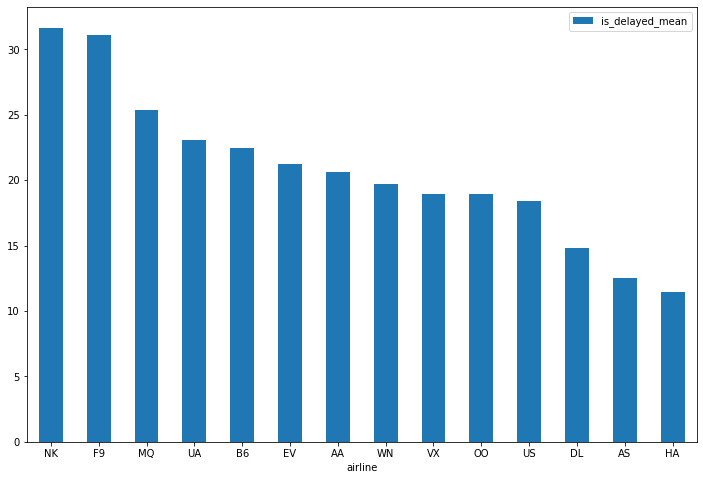

In [22]:
# you should get
# 
# NK   31.661
# F9   31.106
# MQ   25.388
# UA   23.082
# B6   22.461
# EV   21.207
# AA   20.621
# WN   19.720
# VX   18.968
# OO   18.935
# US   18.393
# DL   14.817
# AS   12.525
# HA   11.453

# transform target from True/False to 1/0
target_variable = flights_processed['is_delayed'].map(int)

# dataframe with the required data
df_airline_delayed = pd.DataFrame({'airline': flights_processed['airline'].values, 'is_delayed': target_variable.values})
df_airline_delayed['is_delayed'] = df_airline_delayed['is_delayed'].astype(float)

# group by airline and get mean of is_delayed for each value of airline
df_group = df_airline_delayed.groupby('airline').agg(is_delayed_mean = ('is_delayed', 'mean'))

# transform to percentage, sort descending
df_group['is_delayed_mean'] = (df_group['is_delayed_mean'] * 100)
df_group = df_group.sort_values('is_delayed_mean', ascending=False)

# print and bar plot
print(df_group)
df_group.plot.bar(rot=0)

Como podem observar os atrasos variam imenso de companhia aérea para companhia aérea. 
<br><br>
Notem da importância de se efetuar esta análise usando percentagens e não o valor absoluto. Por exemplo, se a companhia aérea X tive 10 voos em atraso e a companhia aérea Y 100, o que isso nos diz? Na verdade muito pouco.. Pois a companhia aérea X pode ter um total de 30 voos e a Y um total de 2000, o que torna a situação bem diferente, não é verdade?

<div class="alert alert-success">
Q.12<br>
    Calcule o número de voos por dia da semana. Se quiser, apresente o resultado num gráfico.
</div>

Sex    436357
Seg    432999
Qui    432714
Ter    421660
Qua    410705
Dom    404134
Sab    350943
Name: day_of_week, dtype: int64


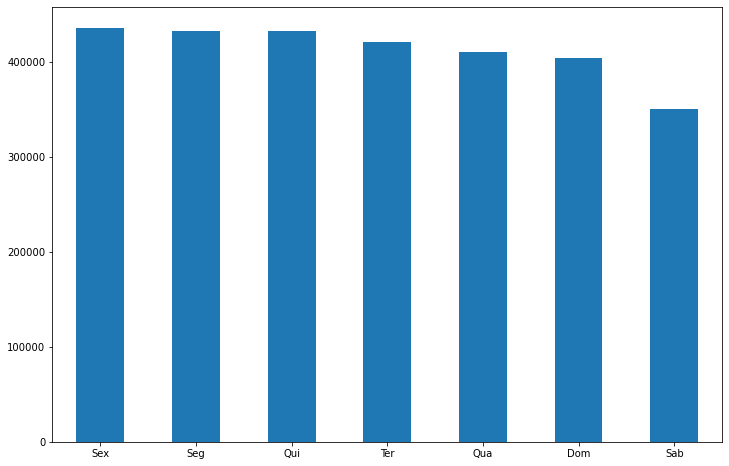

In [23]:
# number of flights per day of week
week_days_count = flights_processed['day_of_week'].value_counts().sort_values(ascending=False)

# print and bar plot
print(week_days_count)
week_days_count.plot.bar(rot=0)

A próxima pergunta é livre, ou seja, o objectivo é com base no que aprenderam até agora explorarem os dados de forma a extrair o máximo de insights úteis para o objetivo final do desafio do Kaggle: prever os voos que se irão atrasar.

<span class="badge">Nota:</span> Senão responderem não serão prejudicados, contudo, quanto mais fizerem mais pontos adicionais terão.

<div class="alert alert-warning">
Q.13<br>
    Apresente uma exploração ao dados feita por si.
</div>

In [24]:
# code here

___
### 5. Desafios
___

Nesta secção terão de fazer um dos desafios. Nos restantes desafios respondidos terão pontos adicionais.

___
#### Problema 1: Implementar one hot enconding (OHE)

O interesse de usar técnicas como [OHE](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f) deve-se ao facto de alguns algoritmos assumirem que todas as colunas são numéricas, limitando imenso os dados que se pode usar. OHE é uma das técnicas que permite dar a volta a esta limitação.

O que o OHE faz é transformar uma coluna categórica (ou string) em `N` novas colunas com o valor 0 ou 1, sendo `N` o número de valores de domínio da coluna.

Veja o seguinte exemplo:

```python
# OHE Example using get_dummies
> df = pd.DataFrame({'country': ['russia', 'germany', 'australia','korea','germany']})
> print(df)

     country
0     russia
1    germany
2  australia
3      korea
4    germany

> pd.get_dummies(df, columns=['country'])

   country_australia  country_germany  country_korea  country_russia
0                  0                0              0               1
1                  0                1              0               0
2                  1                0              0               0
3                  0                0              1               0
4                  0                1              0               0
``` 

Contudo esta abordagem é limitada, pois se tivermos uma coluna com 1 milhão de valores de domínio possíveis, mas apenas 10 importam, adicionar 1 milhão de colunas irá gerar outros problemas. Esta é a abordagem que o pandas permite fazer usando o comando `get_dummies`. 

O que se pretende com este exercício é desenvolver de raíz uma função que implimente o OHE **sem usar nenhuma biblioteca que já calcule OHE** (como o `get_dummies` ou o `sklearn.preprocessing.OneHotEncoder`) passando por argumento os valores de domínio a considerar. Ou seja:

Escrever a função:

```python
def apply_ohe(df, column, categories)
```

que dado um dataframe `df`, a coluna `column` a considerar e uma lista de valores de domínio `categories` devolve o mesmo dataframe original com a respetiva transformação usando OHE.

Por exemplo:

```python
> df = pd.DataFrame({'country': ['russia', 'germany', 'australia','korea','germany']})
> print(df)

     country
0     russia
1    germany
2  australia
3      korea
4    germany

> apply_ohe(df, 'country', ['russia', 'australia'])

     country  country_russia  country_australia
0     russia               1                  0
1    germany               0                  0
2  australia               0                  1
3      korea               0                  0
4    germany               0                  0
``` 

In [25]:
# code here

def add_category_encode_to_dataframe(df, series_name, category):
    df[f'{series_name}_{category}'] = (df[series_name] == category).map(int)

def apply_ohe(df, column, categories):
    list(map(lambda x: add_category_encode_to_dataframe(df, column, x), categories))


df = pd.DataFrame({'country': ['russia', 'germany', 'australia','korea','germany']})
print(df)
apply_ohe(df, 'country', ['russia', 'australia'])
df

     country
0     russia
1    germany
2  australia
3      korea
4    germany


,country,country_russia,country_australia
0,russia,1,0
1,germany,0,0
2,australia,0,1
3,korea,0,0
4,germany,0,0


___
#### Problema 2: PermCheck do Codility.
</div>

https://app.codility.com/programmers/lessons/4-counting_elements/perm_check/

Uma permutação é uma sequência de tamanho `N` que contem todos os elementes de 1 até `N`, uma e uma só vez.

Por exemplo, a seguinte lista A:

```python
    A[0] = 4
    A[1] = 1
    A[2] = 3
    A[3] = 2
```

é uma permutação, mas a seguinte lista A:

```python
    A[0] = 4
    A[1] = 1
    A[2] = 3
```

já não o é, pois falta o valor 2. 

O objectivo é verificar que uma dada lista A é uma permutação.

Escrever uma função:

```python
def solution(A)
```

que, dado uma lista `A` retorna 1 se `A` for uma permutação e 0 caso contrário.


Por exemplo, para a seguinte lista `A`:

```python
    A[0] = 4
    A[1] = 1
    A[2] = 3
    A[3] = 2
```

a função deve retornar 1.

E para a seguinte lista `A`:

```python
    A[0] = 4
    A[1] = 1
    A[2] = 3
```

a função deve retornar 0.

In [26]:
# code here

def solution(A):
    min_value = 1
    max_value = max(A)
    
    control_list = range(min_value, max_value+1)
    if (len(A) != len(control_list)):
        return 0
    
    existence_list = list(map(lambda element: (element in A), control_list))
    if (False in existence_list):
        return 0
    
    return 1
    
    
A = [4, 1, 3, 2]
B = [4, 1, 3]
C = [3, 1, 2, 2]
E = [1]
F = [2]

print(solution(A))
print(solution(B))

assert solution(A) == 1 # true
assert solution(B) == 0 # false due to non continuity and different length
assert solution(C) == 0 # false due to repeated element
assert solution(E) == 1 # true
assert solution(F) == 0 # false due to missing elements and different length

1
0


___
#### Problema 3: MaxCounters do Codility.

https://app.codility.com/programmers/lessons/4-counting_elements/max_counters/

Dada uma lista contador de tamanho `N`, iniciada com 0 em todas as entradas, duas operações são permitidas:

* aumentar(X) - o índice X é incrementado de 1,
* valor max - todas os índices são alterados para o valor máximo que se encontra na lista.

Uma lista `A` de tamanho `M` é dada com operações consecutivas:

* se A[K] = X, tal que 1 ≤ X ≤ N, então a operação K é aumentar(X)
* se A[K] = N + 1, então a operação é valor max

Por exemplo, dado `N = 5` e a segunte lista `A`:

```python
    A[0] = 3
    A[1] = 4
    A[2] = 4
    A[3] = 6
    A[4] = 1
    A[5] = 4
    A[6] = 4
```

os valores da lista contador a seguir a cada operação serão os seguintes:

```python
    (0, 0, 1, 0, 0)
    (0, 0, 1, 1, 0)
    (0, 0, 1, 2, 0)
    (2, 2, 2, 2, 2)
    (3, 2, 2, 2, 2)
    (3, 2, 2, 3, 2)
    (3, 2, 2, 4, 2)
```

O objectivo é calcular o valor da lista contador após cada operação.

Escrever uma função:

```python
def solution(N, A)
```

que, dada um valor inteiro `N` e uma lista `A` com `M` operações, retorna a lista contador apoś aplicar todas as operações.

Por exemplo, dado:

```python
    A[0] = 3
    A[1] = 4
    A[2] = 4
    A[3] = 6
    A[4] = 1
    A[5] = 4
    A[6] = 4
```

a função deve retornar [3, 2, 2, 4, 2].

In [27]:
# code here

A = [3, 4, 4, 6, 1, 4, 4]
N = 5

def solution(N, A):
    N_counter = [0] * N + [0]
    
    for i in range(len(A)):
        if A[i]<N:
            N_counter[A[i]] = N_counter[A[i]] + 1
            
        elif A[i]==N+1:
            for x in range(len(N_counter)):
                N_counter[x] = max(N_counter)
                
    return N_counter[1:]

result = solution(N, A)
print(result)

expected_result = [3, 2, 2, 4, 2]
assert result == expected_result

[3, 2, 2, 4, 2]
